In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_data(sign_V="positive", gap_or_sigma="energy_gap", include_path = False, mu_V_ratios = None, J_V_ratios = None):
    """
    Reads the CSV file corresponding to the chosen V sign and quantity,
    and plots the data using pcolormesh.
    
    Parameters:
      sign_V (str): Either "positive" for V>0 or "negative" for V<0.
      gap_or_sigma (str): Either "energy_gap" or "sigma".
    """
    # Construct the filename from the given options.
    filename = f"{gap_or_sigma}_V_{sign_V}.csv"
    try:
        # Load data from CSV. The first line is a header.
        data = np.genfromtxt(filename, delimiter=",", skip_header=1)
    except IOError:
        print(f"Error: File {filename} not found.")
        return

    # The CSV file columns are: mu_V_ratio, J_V_ratio, value.
    # Determine the unique coordinate values.
    unique_mu = np.unique(data[:, 0])
    unique_J = np.unique(data[:, 1])
    
    # The data were saved in a grid of shape (len(J), len(mu)).
    # Reshape the values accordingly.
    Z = data[:, 2].reshape(len(unique_J), len(unique_mu))
    
    # If plotting the energy gap, apply the same transformation as in your original code.
    if gap_or_sigma == "energy_gap":
        # Avoid division by zero if any gap is zero.
        with np.errstate(divide='ignore'):
            Z = np.log(1 / Z)
        plot_title = "Energy Gap"
        color_label = r"$\log(1/\Delta E)$"
    else:
        plot_title = "Synthetic Distance"
        color_label = r"$\sigma/M$"
    
    # Create a meshgrid for pcolormesh.
    # Note: In the original simulation, the x-axis corresponds to J/|V| and the y-axis to mu/|V|.
    # Here, we set up the grid accordingly.
    # Since the CSV file was built from meshgrid(mu_V, J_V) with shape (len(J_V), len(mu_V)),
    # we create the grid with indexing 'ij'.
    J_grid, mu_grid = np.meshgrid(unique_J, unique_mu, indexing='ij')
    
    # Generate the plot.
    plt.figure(figsize=(8, 6))
    pcm = plt.pcolormesh(J_grid, mu_grid, Z, shading='auto', cmap='plasma')
    
    if include_path is not None:
        plt.plot(J_V_ratios, mu_V_ratios, '-w', label = "path")
        plt.legend(loc = "upper left")
    
    sign_str = r"$V > 0$" if sign_V == "positive" else r"$V < 0$"
    plt.title(f"{plot_title}: {sign_str}", fontsize=14)
    plt.xlabel(r"$J/|V|$", fontsize=12)
    plt.ylabel(r"$\mu/|V|$", fontsize=12)
    plt.colorbar(pcm, label=color_label)
    plt.tight_layout()
    plt.show()

#plot_data(sign_V="negative", gap_or_sigma="sigma")


In [3]:
def lambda_t(t, T):
    """
    Function enforcing boundary conditions such that \lambda(t) -> \infty as t -> 0 or t -> T using a rational function.
    """
    return 1 / (t * (T - t))

def crab_ansatz(t, T, A, B, omega, N_c):
    """
    Implements the CRAB ansatz for a control parameter with N_c basis functions.
    """
    sum_terms = np.sum([A[n] * np.sin(omega[n] * t) + B[n] * np.cos(omega[n] * t) for n in range(N_c)], axis=0)
    return 1 + sum_terms / lambda_t(t, T)

def J_V_ratio_CRAB_ansatz(t, T, A_J, B_J, omega_J, J_V_init, J_V_final, N_c):
    """
    Implements the CRAB ansatz for J/V with boundary constraints.
    """
    return (J_V_init + (t / T) * (J_V_final - J_V_init)) * crab_ansatz(t, T, A_J, B_J, omega_J, N_c)

def mu_V_ratio_CRAB_ansatz(t, T, A_mu, B_mu, omega_mu, mu_V_init, mu_V_final, N_c):
    # Implements the CRAB ansatz for mu/V with boundary constraints.
    return (mu_V_init + (t / T) * (mu_V_final - mu_V_init)) * crab_ansatz(t, T, A_mu, B_mu, omega_mu, N_c)


# Optimization setup
N = 2
M = 2
V = -1
T = 5
dt = 0.05
times = np.arange(0, T + dt, dt)

J_V_init = 0
J_V_final = 0.5
mu_V_init = 10
mu_V_final = 0
N_c = 10  # You can change this parameter here for different N_c

# Initial guess for parameters (N_c = 5, so 3*N_c parameters for each of J and mu)
initial_guess = np.random.uniform(-1, 1, 2 * 3 * N_c)  # 3*N_c for A_J, B_J, omega_J and A_mu, B_mu, omega_mu

def objective_function(params, N_c, times, T, N, M, V, J_V_init, J_V_final, mu_V_init, mu_V_final):
    A_J, B_J, omega_J = params[:N_c], params[N_c:2*N_c], params[2*N_c:3*N_c]
    A_mu, B_mu, omega_mu = params[3*N_c:4*N_c], params[4*N_c:5*N_c], params[5*N_c:6*N_c]
    
    hamiltonians = []
    for t in times:
        J_ratio = J_V_ratio_CRAB_ansatz(t, T, A_J, B_J, omega_J, J_V_init, J_V_final, N_c)
        mu_ratio = mu_V_ratio_CRAB_ansatz(t, T, A_mu, B_mu, omega_mu, mu_V_init, mu_V_final, N_c)
        hamiltonians.append(construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_ratio, J_V_ratio=J_ratio))
    
    energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies = \
        simulate_hamiltonian_time_evolution(hamiltonians, times)
    
    ground_state_fidelity = state_probabilities[-1, 0]
    ground_state_infidelity = 1 - ground_state_fidelity
    return ground_state_infidelity

def objective_function_with_penalty(params, N_c, times, T, N, M, V, J_V_init, J_V_final, mu_V_init, mu_V_final):
    A_J, B_J, omega_J = params[:N_c], params[N_c:2*N_c], params[2*N_c:3*N_c]
    A_mu, B_mu, omega_mu = params[3*N_c:4*N_c], params[4*N_c:5*N_c], params[5*N_c:6*N_c]
    
    penalty = 0
    hamiltonians = []
    for t in times:
        J_ratio = J_V_ratio_CRAB_ansatz(t, T, A_J, B_J, omega_J, J_V_init, J_V_final, N_c=N_c)
        mu_ratio = mu_V_ratio_CRAB_ansatz(t, T, A_mu, B_mu, omega_mu, mu_V_init, mu_V_final, N_c=N_c)
        
        # Add penalty for negative mu(t)
        penalty += np.sum(np.maximum(0, -mu_ratio))  # Add penalty if mu(t) is negative
        
        hamiltonians.append(construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_ratio, J_V_ratio=J_ratio))
    
    energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies = \
        simulate_hamiltonian_time_evolution(hamiltonians, times)
    
    ground_state_fidelity = state_probabilities[-1, 0]
    ground_state_infidelity = 1 - ground_state_fidelity
    return ground_state_infidelity + penalty  # Minimize both infidelity and penalty

# Run the optimization
result = minimize(objective_function_with_penalty, initial_guess, 
                  args=(N_c, times, T, N, M, V, J_V_init, J_V_final, mu_V_init, mu_V_final), 
                  method='Nelder-Mead')

optimized_params = result.x
J_V_ratio_params_optimized = optimized_params[:3 * N_c]
mu_V_ratio_params_optimized = optimized_params[3 * N_c:]

print(f"Optimized J_V_ratio parameters: {J_V_ratio_params_optimized}")
print(f"Optimized mu_V_ratio parameters: {mu_V_ratio_params_optimized}")


Optimized J_V_ratio parameters: [ 1.93187191e-03  1.96536371e-01  1.15111761e+00 -3.51398670e-03
 -5.32336694e-01  2.99163758e-01 -6.89992580e-01  3.25681461e-01
 -5.79256822e-01 -6.06221858e-01 -9.06239197e-01 -4.30075794e-01
 -3.17359266e-01  5.51064461e-01  3.31040615e+00  6.43614962e-01
 -1.03343945e-01 -4.18266794e-01  2.70788195e-01  4.73954087e-01
 -6.06216183e-01 -4.57594266e-02 -9.76779018e-02 -1.51066700e+00
 -2.65529896e-01  1.01331483e+00 -1.25790472e+00  4.43190232e-03
  1.07290803e-01 -7.46200531e-01]
Optimized mu_V_ratio parameters: [ 0.72786992 -0.72877374 -0.85986462 -1.8637834  -0.1985533   0.81077646
  0.65726517  0.25482681  0.76663213  0.13830813  0.13803407 -0.68389296
  0.63965523 -0.50614705  0.20595545  0.1743564  -0.10840117 -0.10912341
  0.27546555 -0.86786133 -0.76777835  0.03888193  0.23097461 -0.73213855
  0.07921521 -0.02865075 -1.00220714  0.03110034  1.10642883  0.47153259]


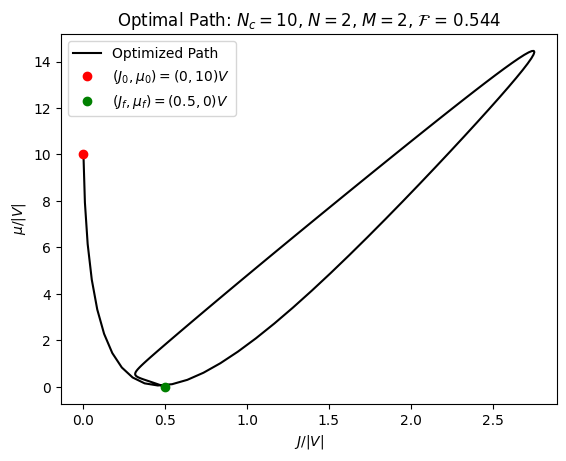

In [15]:
# Extract optimized parameters for J_V_ratio and mu_V_ratio
A_J = optimized_params[:N_c]
B_J = optimized_params[N_c:2*N_c]
omega_J = optimized_params[2*N_c:3*N_c]
A_mu = optimized_params[3*N_c:4*N_c]
B_mu = optimized_params[4*N_c:5*N_c]
omega_mu = optimized_params[5*N_c:6*N_c]

# Generate the optimized J/V and mu/V ratios using the CRAB ansatz with the optimized parameters
J_V_ratios_optimized = np.array([J_V_ratio_CRAB_ansatz(t, T, A_J, B_J, omega_J, J_V_init, J_V_final, N_c) for t in times])
mu_V_ratios_optimized = np.array([mu_V_ratio_CRAB_ansatz(t, T, A_mu, B_mu, omega_mu, mu_V_init, mu_V_final, N_c) for t in times])

# Compute the Hamiltonian evolution with the optimized parameters
hamiltonians_optimized = []

for t in times:
    J_V_ratio = J_V_ratio_CRAB_ansatz(t, T, A_J, B_J, omega_J, J_V_init, J_V_final, N_c)
    mu_V_ratio = mu_V_ratio_CRAB_ansatz(t, T, A_mu, B_mu, omega_mu, mu_V_init, mu_V_final, N_c)
    hamiltonians_optimized.append(construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=J_V_ratio, J_V_ratio=mu_V_ratio))

# Simulate the time evolution and get state probabilities
results = simulate_hamiltonian_time_evolution(hamiltonians_optimized, times)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies = results

# Calculate the ground state infidelity (1 - fidelity)
ground_state_fidelity = state_probabilities[-1, 0]
ground_state_infidelity = 1 - ground_state_fidelity

# Plot the optimized J/V and mu/V ratios
fig, ax = plt.subplots()
ax.plot(J_V_ratios_optimized, mu_V_ratios_optimized, '-k', label="Optimized Path")

# Plot initial and final points
ax.plot(J_V_init, mu_V_init, 'or', label=f"$(J_0, \\mu_0) = ({J_V_init}, {mu_V_init})V$")
ax.plot(J_V_final, mu_V_final, 'og', label=f"$(J_f, \\mu_f) = ({J_V_final}, {mu_V_final})V$")

# Set labels, axis limits, and legend
ax.set_xlabel("$J/|V|$")
ax.set_ylabel("$\\mu/|V|$")
ax.legend()

plt.title(f"Optimal Path: $N_c = {N_c}$, $N = {N}$, $M={M}$,"+" $\\mathcal{F}$ = "+f"{np.round(ground_state_fidelity,3)}")

plt.show()


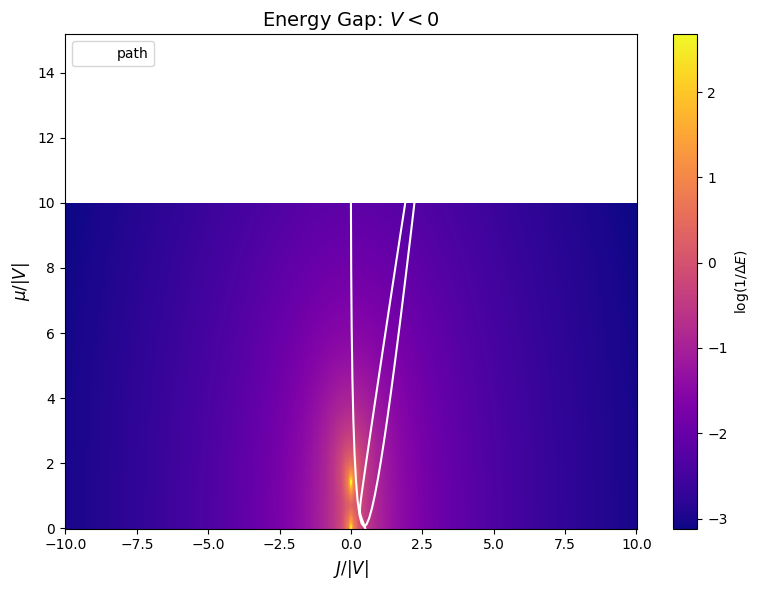

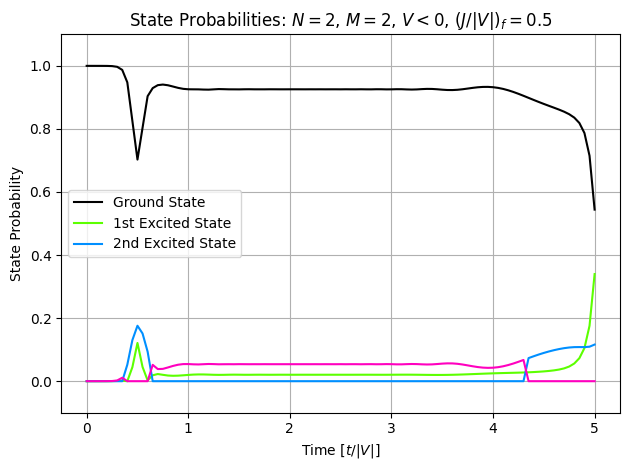

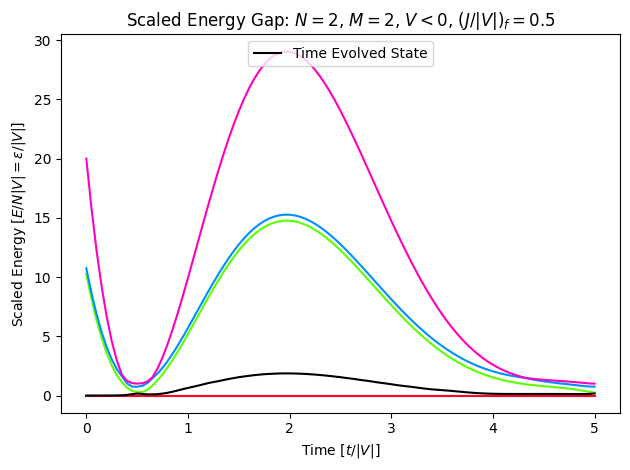

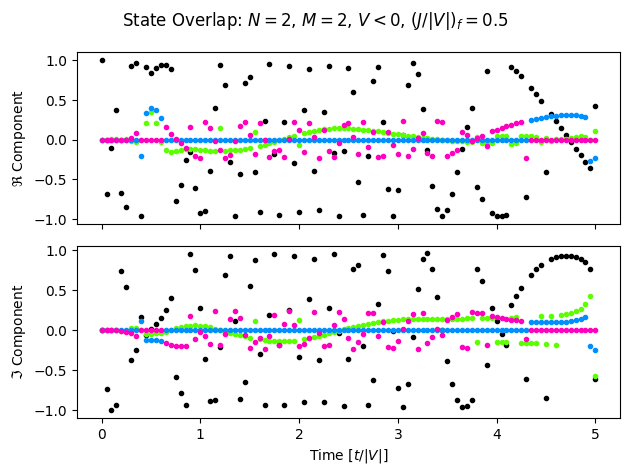

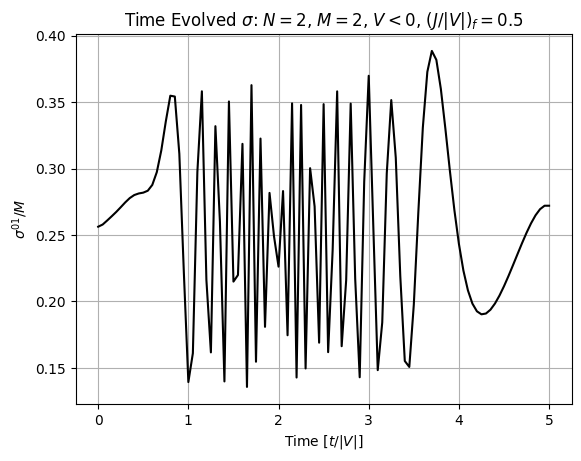

In [16]:
plot_data(sign_V="negative", gap_or_sigma="energy_gap", include_path = True, mu_V_ratios = mu_V_ratios_optimized, J_V_ratios = J_V_ratios_optimized)
plot_time_evolution(N,M,results,times,J_V_ratio_routine = J_V_ratios_optimized, mu_V_ratio_routine = mu_V_ratios_optimized)